In [26]:
import torch
import numpy
import pandas as pd
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from utils import plot_confusion_matrix
from torchviz import make_dot
from torchsummary import summary
import torchvision.transforms.functional as TF
from utils import pytorchtools

In [27]:
torch.cuda.empty_cache()

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [29]:
convert_input = lambda images : images.view(images.shape[0], -1).to(device)

### Parameters

In [30]:
input_size = 784
num_classes = 10
num_epochs = 100
patience = 10
batch_size = 512
learning_rate = 0.001

### MNIST dataset 

In [31]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])

In [32]:
train_dataset = torchvision.datasets.MNIST(root='..//set', 
                                           train=True, 
                                           transform=transform,  
                                           download=True)

In [33]:
test_dataset = torchvision.datasets.MNIST(root='..///set', 
                                          train=False, 
                                          transform=transform)

In [34]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### Fully connected neural network

In [35]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        #layers
        self.l1 = nn.Linear(784, 256) # layer 1
        self.l2 = nn.Linear(256, 128) # layer 2
        self.l3 = nn.Linear(128, 64) # layer 3
        self.l4 = nn.Linear(64, 10) # layer 4
        
        self.sigmoid = nn.Sigmoid() 
        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim = 1) 
     
    
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.sigmoid(x)
        x = self.l4(x)
        x = self.softmax(x)
        return x

In [36]:
model = NeuralNet().to(device)

### Architecture

In [37]:
summary(model, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]         200,960
              ReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 128]          32,896
              ReLU-4               [-1, 1, 128]               0
            Linear-5                [-1, 1, 64]           8,256
           Sigmoid-6                [-1, 1, 64]               0
            Linear-7                [-1, 1, 10]             650
        LogSoftmax-8                [-1, 1, 10]               0
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.93
Estimated Total Size (MB): 0.94
----------------------------------------------------------------


### Loss and optimizer

In [38]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

### Train the model

In [39]:
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = []

In [40]:
size = len(train_loader.dataset)
print(size)

# initialize the early_stopping object
early_stopping = pytorchtools.EarlyStopping(patience=patience, verbose=True)

for epoch in range(num_epochs):
    ##########################    
    #######TRAIN MODEL########
    ##########################
    epochs_loss=0
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
#         images = images.view(images.shape[0], -1).to(device)
        labels = labels.to(device)
#         print(images.shape)
        # Forward pass
        outputs = model(images).to(device)
        loss = criterion(outputs, labels)
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        
        #calculate train_loss
        train_losses.append(loss.item())
        optimizer.step()
    
    ##########################    
    #####VALIDATE MODEL#######
    ##########################
    model.eval()
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images).to(device)
        loss = criterion(outputs,labels)
        valid_losses.append(loss.item())
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = numpy.average(train_losses)
    valid_loss = numpy.average(valid_losses)
#     print(train_loss)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    
    print_msg = (f'train_loss: {train_loss:.5f} ' + f'valid_loss: {valid_loss:.5f}')
    
    print(print_msg)

    
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    
    early_stopping(valid_loss, model)
    print(epoch)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break


60000
train_loss: 1.12714 valid_loss: 0.52604
Validation loss decreased (inf --> 0.526040).  Saving model ...
0
train_loss: 0.39695 valid_loss: 0.31223
Validation loss decreased (0.526040 --> 0.312230).  Saving model ...
1
train_loss: 0.26246 valid_loss: 0.23153
Validation loss decreased (0.312230 --> 0.231526).  Saving model ...
2
train_loss: 0.19663 valid_loss: 0.17682
Validation loss decreased (0.231526 --> 0.176822).  Saving model ...
3
train_loss: 0.15630 valid_loss: 0.16701
Validation loss decreased (0.176822 --> 0.167012).  Saving model ...
4
train_loss: 0.12475 valid_loss: 0.12786
Validation loss decreased (0.167012 --> 0.127862).  Saving model ...
5
train_loss: 0.10547 valid_loss: 0.11854
Validation loss decreased (0.127862 --> 0.118535).  Saving model ...
6
train_loss: 0.09154 valid_loss: 0.11108
Validation loss decreased (0.118535 --> 0.111083).  Saving model ...
7
train_loss: 0.07765 valid_loss: 0.09543
Validation loss decreased (0.111083 --> 0.095431).  Saving model ...
8


In [41]:
# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

### Loss function vs Epoch

24


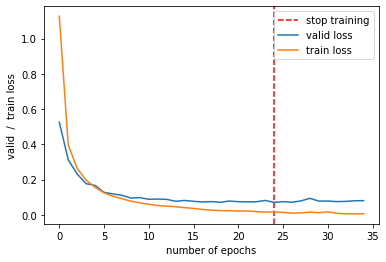

In [42]:
fig = plt.figure()

######1st plot#########
ax1 = fig.add_subplot()
ax1.set_ylabel('valid  /  train loss')
ax1.set_xlabel('number of epochs')
halt = avg_valid_losses.index(min(avg_valid_losses))


plt.axvline(x=halt, color='r', linestyle="--", label="stop training")

print(avg_valid_losses.index(min(avg_valid_losses)))


plt.plot(list(range(len(avg_valid_losses))), avg_valid_losses, label = "valid loss")
plt.plot(list(range(len(avg_valid_losses))), avg_train_losses, label="train loss")

h,labels = ax1.get_legend_handles_labels()
labels[:1] = ['stop training','valid loss', 'train loss',]
ax1.legend(labels=labels)

plt.show()

### Test the model

In [43]:
# In the test phase, don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), '.\\models\\net_custom1`.ckpt')

Accuracy of the network on the 10000 test images: 98.05 %


### Building confusion matrix

In [44]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images = images.reshape(-1,28*28).to(device)
        labels = labels.to(device)

        preds = model(images).to(device)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )
    return all_preds

In [45]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(test_dataset, batch_size =10000)
    train_preds = get_all_preds(model, prediction_loader).to(device)
    
train_preds.shape
train_preds.grad_fn
train_preds.grad

def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

preds_correct = get_num_correct(train_preds, test_dataset.targets.to(device) )
print('total correct', preds_correct)
print('accuracy', preds_correct / len(test_dataset))
train_preds.is_cuda

total correct 9805
accuracy 0.9805


True

In [46]:
stacked = torch.stack((test_dataset.targets.to(device), train_preds.argmax(dim=1)), dim=1)
stacked[9].tolist()
cmt = torch.zeros(10,10, dtype=torch.int64)
for p in stacked:
    j,k = p.tolist()
    cmt[j,k] = cmt[j, k] + 1
    
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [47]:
lb = test_dataset.targets.detach().cpu().numpy()

In [48]:
rp = train_preds.argmax(dim=1).detach().cpu().numpy()
print(rp)

[7 2 1 ... 4 5 6]


In [49]:
cm = confusion_matrix(lb, rp)

In [50]:
names = set(lb)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, names)

TypeError: 'module' object is not callable

<Figure size 720x720 with 0 Axes>

### Image

In [ ]:
dataiter = iter(train_loader) # creating a iterator
images, labels = dataiter.next()
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    model.predict(images[index]).to(device)
    plt.subplot(6, 10, index)
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            target = target.to(device)
            data = data.reshape(-1,28*28).to(device)
            output = model(data)
            
            test_loss += nn.functional.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # Store wrongly predicted images
            wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
            wrong_samples = data[wrong_idx]
            wrong_preds = pred[wrong_idx]
            actual_preds = target.view_as(pred)[wrong_idx]

            for i in range(len(wrong_idx)):
                sample = wrong_samples[i]
                wrong_pred = wrong_preds[i]
                actual_pred = actual_preds[i]
                # Undo normalization
#                 print(wrong_samples[i].shape)
                sample = sample.reshape(28,28).to(device)
                sample = sample * 0.3081
                sample = sample + 0.1307
                sample = sample * 255.
                sample = sample.byte()
                img = TF.to_pil_image(sample)
                path = '.\\mistakes\\net_custom1\\'
                img.save(path+'wrong_idx{}_pred{}_actual{}.png'.format(
                    wrong_idx[i], wrong_pred.item(), actual_pred.item()))

In [ ]:
test(model,device, test_loader)